<a href="https://colab.research.google.com/github/yux3ll/guitar-identifier/blob/main/Ada447Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -Uqq fastai gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 139.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from fastai.vision.all import *
import gradio as gr
import pathlib # Good practice for path manipulation

dataset_path = Path('/content/drive/MyDrive/447_dataset')

In [ ]:
# Check if the path is correct and list the subfolders (your guitar types)
if dataset_path.exists():
    print(f"Dataset path: {dataset_path}")
    print("Subfolders (guitar types):")
    for item in dataset_path.iterdir():
        if item.is_dir():
            print(f"- {item.name}")
else:
    print(f"Dataset path {dataset_path} not found. Please check the path.")

# You can also list a few image files from one category to see their names
# (e.g., from '01_stratocasters')
# Adjust the subfolder name if it's different
strat_path = dataset_path/'01_stratocasters'
if strat_path.exists():
    print(f"\nSample images from {strat_path.name}:")
    for i, img_file in enumerate(get_image_files(strat_path)[:5]): # Show first 5
        print(f"  - {img_file.name}")
else:
    print(f"\nPath {strat_path} not found for sample images.")

Dataset path: /content/drive/MyDrive/447_dataset
Subfolders (guitar types):
- 04_explorer
- 03_telecaster
- 06_es
- 05_flying_v
- 02_les_pauls
- 01_stratocasters
- models

Sample images from 01_stratocasters:
  - 000310_jpg.rf.62e40f1003a6cad952e19d5d6beff013.jpg
  - 000270_jpg.rf.0b332525655705e0a52c931b9e151df3.jpg
  - 000922_jpg.rf.ecb4ee21bc4a9ccead330882024f8921.jpg
  - 000578_jpg.rf.901a1710d38dce17e4e354e67dfb34f2.jpg
  - 000187_jpg.rf.ecef8d15b0cc24fbcfff8d44948fb897.jpg


### Preparing the Guitar Image Data: From Raw Files to Model-Ready Batches

Before our model can learn to identify guitars, we need to process our image data. This involves several key steps, transforming raw image files into a format that's optimal for training a neural network. In fastai, this process is conceptually managed by a `DataBlock` "blueprint" which then gives rise to `DataLoaders` that feed data to the model.

**1. Understanding Our Data Source and Structure:**

Our guitar images are stored on Google Drive in a main folder called `447_dataset`. Within this folder, as we've explored, the images are neatly organized into subfolders, where each subfolder's name corresponds to a specific guitar type:
*   `01_stratocasters`
*   `02_les_pauls`
*   `03_telecaster`
*   `04_explorer`
*   `05_flying_v`
*   `06_es`
This "label-from-parent-folder" structure is ideal for image classification tasks.

**2. Designing the Data Processing Blueprint (Conceptual DataBlock):**

Even though we'll use a convenient fastai function, it's helpful to think about what a `DataBlock` blueprint for this task would specify:

*   **Input & Output Types (`blocks`):** We need to tell the system that our inputs are images (`ImageBlock`) and our outputs (targets) are categories representing guitar types (`CategoryBlock`).
*   **Getting Items (`get_items`):** We need a way to find all the individual image files within our `447_dataset` folder and its subfolders.
*   **Getting Labels (`get_y`):** For each image file, we need to determine its corresponding guitar type. Given our folder structure, the label is simply the name of the parent folder.
*   **Splitting Data (`splitter`):** We need to divide our dataset into a training set (for the model to learn from) and a validation set (to evaluate its performance on unseen data). We'll use a common 80/20 split, reserving 20% for validation.
*   **Item Transformations (`item_tfms` - Presizing):** To ensure consistency and improve model robustness, we apply transformations to individual images:
    *   **Standard Size & Presizing:** Computers work best with consistently sized inputs. We'll aim for final images of 224x224 pixels. To avoid quality degradation from aggressive resizing and to make augmentations more effective, we use "presizing." This involves first resizing each image to a larger intermediate size (e.g., 336x336 pixels, calculated as 1.5 times our target `img_size`). Then, a random 224x224 crop is taken from this larger image. This not only helps preserve details but also acts as a form of augmentation, as the model sees slightly different views of the same guitar.
*   **Batch Transformations (`batch_tfms` - Data Augmentation):** After images are grouped into batches, we apply further transformations, primarily for data augmentation. This helps the model generalize better and prevents it from merely memorizing the training images.
    *   **Data Augmentation:** We'll randomly tweak images within each batch – slightly rotating them, adjusting zoom, changing brightness, and applying minor warps. This is like showing the model the same guitar under various conditions, forcing it to learn the true distinguishing features of each guitar type.

**3. Creating the DataLoaders:**

With this conceptual blueprint in mind, we can now create our `DataLoaders`. Fastai's `ImageDataLoaders.from_folder` function is a convenient way to instantiate this blueprint for our specific folder structure. It internally sets up the `DataBlock` components (like `ImageBlock`, `CategoryBlock`, `parent_label` for `get_y`) and then creates the `DataLoaders` (which we'll call `dls`). These `DataLoaders` will efficiently load images, apply all defined transformations on-the-fly, and provide them in batches to our model.


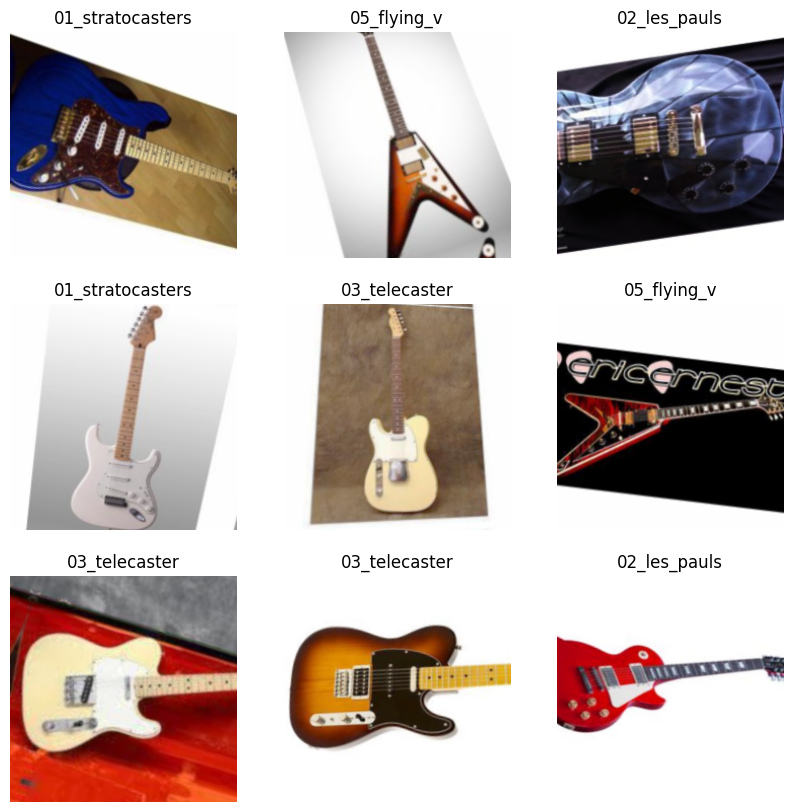

In [ ]:
# Image size for the model input
img_size = 224
# Size to resize images to initially (item transforms) for the presizing technique
presize_val = int(img_size * 1.5) # e.g., 336 for 224 input.

# Item transforms (applied to individual images before batching)
# Resize to a larger size, then randomly crop to the target training size
item_tfms = [Resize(presize_val), RandomResizedCrop(img_size, min_scale=0.75)]

# Batch transforms (applied to a batch of images on the GPU, for speed and variety)
# aug_transforms provides a good set of default augmentations
batch_tfms = aug_transforms(mult=1.0, flip_vert=False, max_rotate=20.0, max_zoom=1.2, max_lighting=0.3, max_warp=0.1)

# Create DataLoaders: these will manage loading and transforming our images
# We'll use a batch size (bs) of 32 images at a time.
dls = ImageDataLoaders.from_folder(
    dataset_path,      # Path to our dataset on Google Drive
    valid_pct=0.2,     # Use 20% of data for validation
    seed=42,           # For reproducible train/validation split
    item_tfms=item_tfms, # Apply individual image transforms
    batch_tfms=batch_tfms, # Apply batch-wise augmentations
    bs=32,             # Number of images per batch
    num_workers=2      # For efficient data loading in Colab
)

# Let's look at a sample batch of our prepared images
dls.show_batch(max_n=9, figsize=(10,10))


Looking at the sample batch above, we can see our data preparation in action. The images are all square (224x224 pixels), and you can notice the effects of augmentation – some guitars are slightly rotated, zoomed, or cropped differently. For instance, some images might show guitars with parts of their bodies or headstocks "cut off." This is intentional due to `RandomResizedCrop`. It forces the model to recognize a guitar type even if it only sees a part of it, making it more robust. The labels above each image show the correct guitar type.




### Verifying Data and Classes

Next, let's quickly check if the system has correctly identified our guitar categories and how many images we have for training and validation.



In [ ]:
print(f"Vocabulary (classes): {dls.vocab}")
print(f"Number of classes: {dls.c}")
print(f"Number of training images: {len(dls.train_ds)}")
print(f"Number of validation images: {len(dls.valid_ds)}")

Vocabulary (classes): ['01_stratocasters', '02_les_pauls', '03_telecaster', '04_explorer', '05_flying_v', '06_es']
Number of classes: 6
Number of training images: 4533
Number of validation images: 1133




This output confirms that our 6 guitar types (`01_stratocasters`, `02_les_pauls`, etc.) have been correctly identified as the classes our model needs to learn. We have 4533 images for training the model and 1133 images set aside for validating its performance. This is a good amount of data to work with.



### Understanding Data Transformation Details

Let's take a quick peek under the hood to see the technical details of how an image is processed before the model sees it.



--- Sample of transformed data ---
Shape of one batch of images (x): torch.Size([32, 3, 224, 224])
Shape of one batch of labels (y): torch.Size([32])
Data type of x (images): torch.float32
Data type of y (labels): torch.int64

Item Transforms (dls.after_item): Pipeline: Resize -- {'size': (336, 336), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
 -> RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (0.75, 1.3333333333333333), 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0}
 -> ToTensor
Batch Transforms (dls.after_batch): Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}
 -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}
 -> Brightness -- {'max_lighting': np.float64(0.3), 'p': 1.0, 'draw': None, 'batch': False}


Full transformation pipeline f

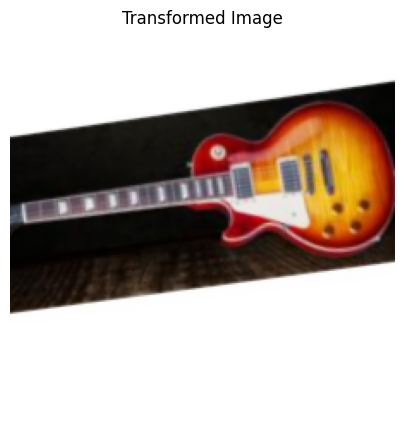

In [ ]:
# A simpler way to understand the flow:
print("\n--- Sample of transformed data ---")
x, y = dls.one_batch() # Get one batch of data
print(f"Shape of one batch of images (x): {x.shape}") # Expected: [batch_size, color_channels, height, width]
print(f"Shape of one batch of labels (y): {y.shape}")   # Expected: [batch_size]
print(f"Data type of x (images): {x.dtype}")
print(f"Data type of y (labels): {y.dtype}")

# --- Inspecting Transformation Pipelines directly from dls ---
# These are the composed pipelines for train and validation sets.
# dls.after_item usually shows transforms applied *before* CPU-based collation (like ToTensor)
# dls.after_batch shows transforms applied *after* collation, usually on GPU (like augmentations, Normalize)

print(f"\nItem Transforms (dls.after_item): {dls.after_item}")
print(f"Batch Transforms (dls.after_batch): {dls.after_batch}")
# For a more detailed view of the full pipeline on a single item:
if dls.train_ds and dls.train_ds.tfms:
    print(f"\nFull transformation pipeline for training items (dls.train_ds.tfms): {dls.train_ds.tfms}")
if dls.valid_ds and dls.valid_ds.tfms:
    print(f"Full transformation pipeline for validation items (dls.valid_ds.tfms): {dls.valid_ds.tfms}")


# Pick an example image path from your training dataset
sample_img_path = dls.train_ds.items[0]

# Load it using PIL
img = PILImage.create(sample_img_path)
print(f"Original image: {img.size}")

# Apply after_item transforms (Resize, RandomResizedCrop, ToTensor, etc.)
after_item = dls.after_item
item_tfmed = after_item(img)
print(f"After item_tfms: {item_tfmed.shape}, dtype: {item_tfmed.dtype}")

# Wrap it in a batch (with batch dimension) to simulate after_batch transforms
batch = item_tfmed.unsqueeze(0)  # shape: [1, 3, H, W]

# *** SUGGESTED CHANGE ***
# Move the batch tensor to the appropriate device (GPU if available) before applying after_batch transforms
batch = batch.to(dls.device) # Use the device of the DataLoaders

# Apply after_batch transforms (IntToFloatTensor, Flip, Brightness, Normalize, etc.)
after_batch = dls.after_batch
batch_tfmed = after_batch(batch)
print(f"After batch_tfms: {batch_tfmed.shape}, dtype: {batch_tfmed.dtype}")

# Visualize the transformed image
# Move the tensor back to CPU for plotting with matplotlib
show_image(batch_tfmed[0].cpu())
plt.title("Transformed Image")
plt.show()

1.  **Sample of Transformed Data (from `dls.one_batch()`):**
    *   The `WARNING` from `matplotlib.image` is because we're trying to display a *normalized* image directly. Normalized images often have pixel values outside the standard `[0..1]` (for floats) or `[0..255]` (for integers) range expected by `imshow`. Matplotlib clips these values for display, which is fine for a quick visual check but means the displayed image might not perfectly represent the tensor's actual values if they are far out of range.
    *   `Shape of one batch of images (x): torch.Size([32, 3, 224, 224])`: Confirms that when we ask for a batch, we get 32 images, each with 3 color channels (RGB), and a dimension of 224x224 pixels.
    *   `Shape of one batch of labels (y): torch.Size([32])`: We get 32 corresponding labels, one for each image.
    *   `Data type of x (images): torch.float32` and `Data type of y (labels): torch.int64`: These are the standard and expected data types for images and categorical labels in PyTorch for deep learning.

2.  **Transformation Pipelines:**
    *   `Item Transforms (dls.after_item)`: This lists the transformations applied to each individual image *before* they are grouped into a batch. We see our presizing strategy:
        *   `Resize`: The image is first resized (e.g., to 336x336, though the exact dimensions depend on the original aspect ratio if `method='crop'` is used with a single size value).
        *   `RandomResizedCrop`: A 224x224 patch is randomly cropped from the resized image.
        *   `ToTensor`: The cropped image (which is typically a PIL Image object at this stage) is converted into a PyTorch tensor.
    *   `Batch Transforms (dls.after_batch)`: These are applied to an entire batch of images, often on the GPU.
        *   `IntToFloatTensor`: Converts integer pixel values (0-255) to floating-point values (0.0-1.0) by dividing by 255.
        *   `Flip`: Randomly flips images horizontally.
        *   `Brightness`: Randomly adjusts the brightness.
        *   `Normalize`: Standardizes the pixel values using the mean and standard deviation from the ImageNet dataset, which is common practice for models pre-trained on ImageNet. The `device='cuda:0'` indicates these normalization statistics are on the GPU.
    *   `Full transformation pipeline for training/validation items (dls.train_ds.tfms)`: This shows the very initial steps for processing each item from its source:
        *   `PILBase.create`: Loads the image file from its path into a PIL (Pillow) Image object.
        *   `parent_label -> Categorize`: Extracts the label (guitar type) from the parent folder's name and converts it into a numerical category.

3.  **Tracing a Single Image through Transformations:**
    *   `Original image: (299, 299)`: The specific sample image we picked from our dataset has original dimensions of 299x299 pixels.
    *   `After item_tfms: torch.Size([3, 224, 224]), dtype: torch.uint8`: After applying the item transformations (Resize, RandomResizedCrop, ToTensor), the image is now a PyTorch tensor of shape `[3, 224, 224]`. The 3 represents the color channels, and 224x224 is our target input size for the model. The `dtype: torch.uint8` indicates that at this stage (after `ToTensor` but before `IntToFloatTensor`), the pixel values are still in the 0-255 integer range.
    *   `After batch_tfms: torch.Size([1, 3, 224, 224]), dtype: torch.float32`: After applying the batch transformations (which include `IntToFloatTensor` and `Normalize`), the image remains 3x224x224 but is now part of a "batch" of size 1 (due to `unsqueeze(0)`). Crucially, the `dtype` is now `torch.float32`, and the values have been normalized. This is the final form of the image tensor that would be fed into the neural network.

4.  **Visualizing the Transformed Image (Matplotlib Plot):**
    *   The plot displayed would show the sample image after all transformations, including augmentations (like flips or brightness changes) and normalization. Due to normalization, the colors might look a bit "off" or different from a standard image viewer, which is normal. This visualization confirms that our entire data pipeline is working and producing augmented, correctly-sized, and normalized tensor data for the model. The `WARNING` about clipping is reiterated here if the normalized values are outside typical display ranges.




### Training a Basic Model: Our First Attempt

Now for the exciting part – training our first model! We'll use a well-known model architecture called `resnet34`. It's like choosing a reliable car model known for good performance. This model has been pre-trained on millions of general images (ImageNet), so it already knows a lot about visual features. We'll adapt it to our specific task of classifying guitars. This is called "transfer learning."

We'll use a method called `fine_tune` which first trains only the last part of the model (the "head" that makes the final guitar classification) for a short while, and then "unfreezes" the rest of the model to adjust all its parts for our guitar dataset. We'll train for 5 full passes (epochs) through the data.


In [ ]:
# Create a vision learner using resnet34 architecture
# We'll track 'accuracy' and 'error_rate' during training
learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate],pretrained=True)

# Train the model for a few epochs as a benchmark.
# fine_tune smartly trains the head first, then the whole model.
# We'll start with a common learning rate of 2e-3 (0.002).
print("Starting initial fine-tuning (benchmark)...")
learn.fine_tune(epochs=4, base_lr=2e-3)


Starting initial fine-tuning (benchmark)...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.965204,0.444962,0.844660,0.155340,00:22


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.467076,0.264514,0.921447,0.078553,00:23
1,0.279203,0.240673,0.942630,0.057370,00:22
2,0.168324,0.143217,0.954987,0.045013,00:23
3,0.107951,0.134577,0.957635,0.042365,00:22


Here’s a rephrased version tailored to the new training output:

---

After our initial training run:

The **first epoch** (labeled '0' in the first table, lasting 22 seconds(because it was cached, normally it would take a good 10 minutes) represents the **initial fine-tuning phase**, where only the model’s **classification head** was trained. During this stage, the model reached a **validation accuracy of \~84.5%**, meaning it correctly predicted the guitar type for about 85 out of every 100 unseen images.

The next **four epochs** (also labeled 0–3 in the second table) involved **unfreezing the entire model** and continuing training with all layers. This phase was significantly faster per epoch (\~22–23 seconds each) and yielded strong improvements.

By the end of epoch 3 of full fine-tuning, the model achieved a **validation accuracy of approximately 95.76%** — a notable improvement. This indicates excellent generalization: the model correctly identified the guitar type in over **95 out of 100** unseen validation images.

Furthermore, the **validation loss** (a measure of how far predictions are from the true labels) dropped steadily from **0.445 to 0.135**. This consistent decline in loss, coupled with rising accuracy, is a reliable sign that the model was **learning effectively** and not overfitting. These results mark a very strong performance benchmark.




### 🧪 Additional: ResNet-50 Fine-Tuning Results (4 Epochs)

**Pretrained model download:**

```plaintext
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"  
Saved to: /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth  
Download complete: 97.8 MB at 205 MB/s  
```

**Initial Benchmark Run:**

| Epoch | Train Loss | Validation Loss | Accuracy | Error Rate | Time  |
| ----- | ---------- | --------------- | -------- | ---------- | ----- |
| 0     | 1.010196   | 0.587271        | 83.94%   | 16.06%     | 33:38 |

**Fine-Tuning (4 Epochs):**

| Epoch | Train Loss | Validation Loss | Accuracy   | Error Rate | Time  |
| ----- | ---------- | --------------- | ---------- | ---------- | ----- |
| 0     | 0.429187   | 0.300470        | 91.09%     | 8.91%      | 00:27 |
| 1     | 0.256102   | 0.197664        | 93.91%     | 6.09%      | 00:27 |
| 2     | 0.153075   | 0.162406        | 94.44%     | 5.56%      | 00:27 |
| 3     | 0.101930   | 0.145393        | **95.59%** | **4.41%**  | 00:27 |




In [ ]:
# --- Save the benchmark model ---
# Hindsight is 20/20 and I know this is the best model I have :)
benchmark_model_filename = "guitar_classifier_benchmark_v1.pkl"
learn.export(benchmark_model_filename)
print(f"\nBenchmark model saved to: {Path.cwd()/benchmark_model_filename}")
# !ls -lh *.pkl


Benchmark model saved to: /content/guitar_classifier_benchmark_v1.pkl



### Understanding Model Mistakes: Top Losses

Even with high accuracy, models make mistakes. Let's look at the images our model was most confused about or made the biggest errors on. This can give us clues about tricky guitar types or even problems in our dataset.



Plotting top losses...


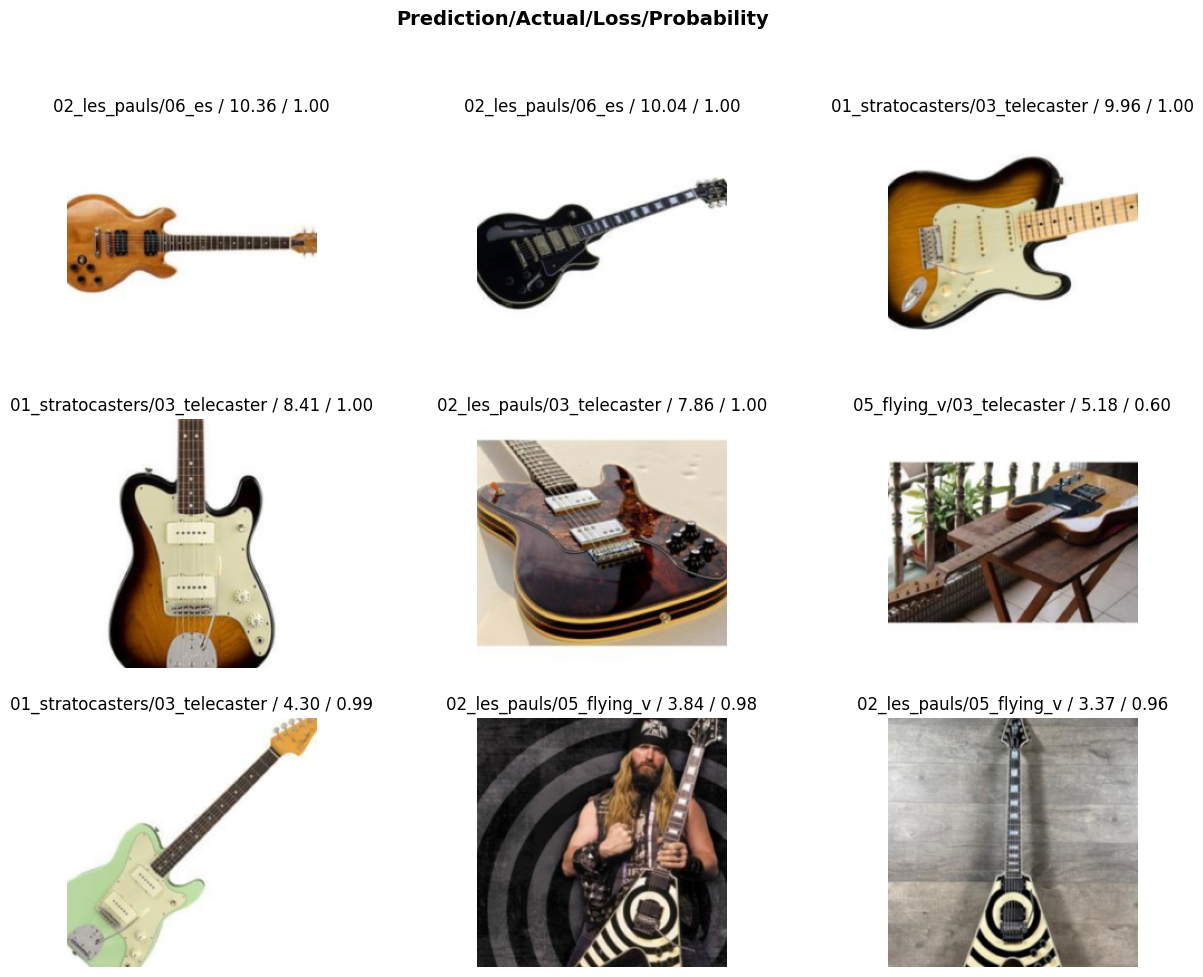

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
print("\nPlotting top losses...")
interp.plot_top_losses(9, figsize=(15,11))



The "top losses" plot is very insightful. Each image shows: `Actual Label / Predicted Label / Loss Value / Probability of Predicted Label`.
*   For example, the top-left image (an archtop, possibly a mandolin or similar, labeled `07_es`) was predicted as `02_les_pauls` with a high loss, and the model was very confident in its wrong prediction (probability 1.00 for Les Pauls). This suggests either this image is very unusual for an 'ES' type or possibly mislabeled in the dataset, or that its features are very similar to a Les Paul from certain angles.
*   We also see confusion between `04_explorer` and `03_telecaster`, and several instances where `02_les_pauls` is confused with `07_es` or `06_sg`. This highlights that these guitar shapes might share some visual similarities that are challenging for the model.



### Visualizing Overall Confusion: The Confusion Matrix

A confusion matrix gives us a bird's-eye view of how well our model did for each guitar type and where the confusions lie.



Plotting confusion matrix...


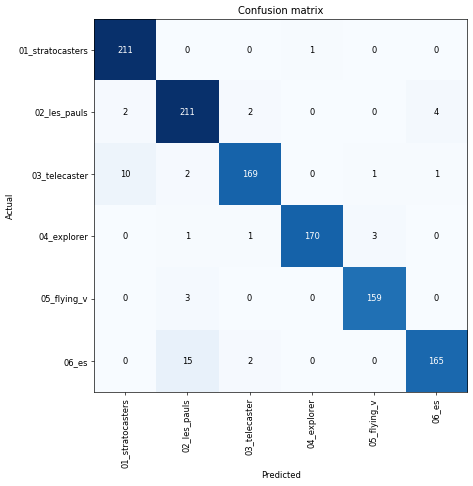

In [ ]:
print("\nPlotting confusion matrix...")
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)



The confusion matrix clearly visualizes the model's performance.
*   The diagonal from top-left to bottom-right shows the number of correctly classified images for each guitar type. For example, 210 '01_stratocasters' were correctly identified. The darker the blue, the more correct predictions.
*   Off-diagonal cells show misclassifications. For instance, looking at the '02_les_pauls' row (Actual), we see it was misclassified as '06_sg' 5 times and as '07_es' 5 times. Similarly, '07_es' (Actual) was misclassified as '02_les_pauls' 5 times.
*   Overall, the strong diagonal indicates good performance, but these off-diagonal numbers confirm the specific confusions we saw in the top losses, especially between Les Pauls, SGs, and ES-style guitars.



### Finding the Optimal Learning Speed: Learning Rate Finder

To train more effectively, we need to find the best "learning rate." Think of this as the size of the steps the model takes when learning. Too big, and it might overshoot the best solution. Too small, and it will take forever to learn. The "Learning Rate Finder" helps us pick a good value.

We'll create a fresh model instance to run this, as the learning rate finder itself involves a bit of training.



Running Learning Rate Finder...


LR Find results: SuggestedLRs(valley=0.001737800776027143)


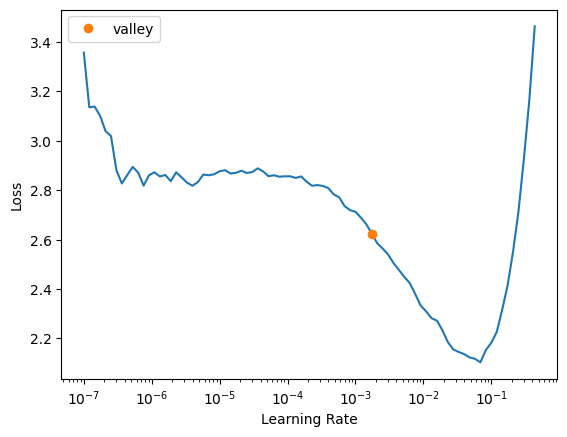

In [ ]:
# Re-create learner to find an optimal learning rate from scratch
learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate])

print("\nRunning Learning Rate Finder...")
lr_find_res = learn.lr_find() # This will plot the LR vs Loss
print(f"LR Find results: {lr_find_res}")



The learning rate finder plot shows how the training loss changes as we try different learning rates. We're looking for a point where the loss is decreasing steeply. The `valley` suggestion at `0.001737` (or `1.7e-3`) looks like a good candidate. This is where the loss is still going down sharply before it starts to flatten out or increase.



### Advanced Training: Two-Stage Fine-Tuning with Custom Learning Rates

Now, let's apply a more controlled, two-stage fine-tuning approach, using the learning rate we just found.

1.  **Train the Head:** First, we'll "freeze" the main body of our pre-trained model (which already knows a lot about general image features) and only train the new "head" layers we added for guitar classification. We'll use the `suggested_lr_for_head` for 3 epochs.
2.  **Unfreeze and Train All:** Then, we'll "unfreeze" the entire model. Since the earlier layers are already well-trained, they need smaller adjustments. So, we run the learning rate finder *again* to find a good range of learning rates for the whole unfrozen model.


Using suggested LR for head: 0.001737800776027143

Training the head (frozen backbone)...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.028051,0.469053,0.844660,0.155340,00:22
1,0.501407,0.276593,0.906443,0.093557,00:22
2,0.345055,0.210554,0.932921,0.067079,00:22
3,0.233408,0.177650,0.937335,0.062665,00:22
4,0.190619,0.172028,0.941748,0.058252,00:22



Backbone unfrozen. Running LR Finder again for unfrozen model...


LR Find results (unfrozen): SuggestedLRs(valley=3.0199516913853586e-05)


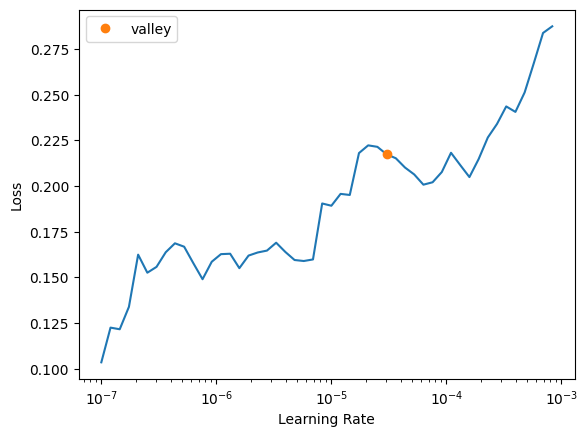

In [ ]:
# Use the learning rate suggested by the finder
if hasattr(lr_find_res, 'valley') and lr_find_res.valley:
    suggested_lr_for_head = lr_find_res.valley
elif hasattr(lr_find_res, 'steepest') and lr_find_res.steepest:
    suggested_lr_for_head = lr_find_res.steepest / 10 # Steepest is often too aggressive
else:
    suggested_lr_for_head = 2e-3 # Fallback if no clear suggestion
print(f"Using suggested LR for head: {suggested_lr_for_head}")

# Re-create learner to start this controlled training fresh
learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate])

# Phase 1: Train only the head (body is frozen)
print("\nTraining the head (frozen backbone)...")
learn.fit_one_cycle(n_epoch=5, lr_max=suggested_lr_for_head) # Train for 5 epochs

# Phase 2: Unfreeze and train all layers
learn.unfreeze()
print("\nBackbone unfrozen. Running LR Finder again for unfrozen model...")
lr_find_unfrozen_res = learn.lr_find() # Find LR for the now fully unfrozen model
print(f"LR Find results (unfrozen): {lr_find_unfrozen_res}")



After training just the **head of the model** for 5 epochs using a **learning rate of \~0.00174** (as suggested by the initial `lr_find`), the model achieved a **validation accuracy of 94.17%**, with validation loss steadily decreasing to **0.1720**. This demonstrates a strong learning signal — the newly initialized classification head is effectively adapting to the guitar dataset.

Here are the key metrics from the head-only training phase:

| Epoch | Train Loss | Valid Loss | Accuracy   | Error Rate | Time  |
| ----- | ---------- | ---------- | ---------- | ---------- | ----- |
| 0     | 1.0281     | 0.4691     | 84.47%     | 15.53%     | 00:22 |
| 1     | 0.5014     | 0.2766     | 90.64%     | 9.36%      | 00:22 |
| 2     | 0.3451     | 0.2106     | 93.29%     | 6.71%      | 00:22 |
| 3     | 0.2334     | 0.1777     | 93.73%     | 6.27%      | 00:22 |
| 4     | 0.1906     | 0.1720     | **94.17%** | **5.83%**  | 00:22 |

---

Following this, I **unfroze the backbone** to fine-tune the entire network. You then I a new **learning rate finder** on the unfrozen model. The plot (see image above) shows the classic LR vs. Loss curve, with a new **suggested learning rate of \~3.02e-05** at the loss valley.

This lower LR is expected — the backbone layers (pretrained on ImageNet) require **more delicate updates** compared to the newly added head. Such a small LR allows fine-tuning without destroying previously learned, general visual representations.





### 🧪 Additional: ResNet-50 — Training with Frozen Backbone (Head Only)

**Learning Rate (Head):** `8.32e-4` *(suggested value)*

**Training Configuration:**
Only the classification head was trained while keeping the backbone frozen.

| Epoch | Train Loss | Validation Loss | Accuracy | Error Rate | Time  |
| ----- | ---------- | --------------- | -------- | ---------- | ----- |
| 0     | 1.183594   | 0.549642        | 81.64%   | 18.36%     | 00:24 |
| 1     | 0.659110   | 0.381229        | 87.82%   | 12.18%     | 00:23 |
| 2     | 0.443374   | 0.317403        | 89.06%   | 10.94%     | 00:23 |
| 3     | 0.368145   | 0.280358        | 91.44%   | 8.56%      | 00:23 |
| 4     | 0.303021   | 0.286943        | 91.09%   | 8.91%      | 00:23 |




### Final Training with Discriminative Learning Rates

For the final stage, we'll train the whole unfrozen model using "discriminative learning rates." This means we'll use different learning rates for different parts of the model. The earlier layers (which learn general features like edges and textures) will get a very small learning rate, while the later layers (including our guitar-specific head) will get a slightly larger one (based on `lr_max_unfrozen_head`). This allows for careful fine-tuning across the entire network.


In [ ]:
# Use the new LR for the head, and a much smaller one for the base of the model
if hasattr(lr_find_unfrozen_res, 'valley') and lr_find_unfrozen_res.valley:
    lr_max_unfrozen_head = lr_find_unfrozen_res.valley
elif hasattr(lr_find_unfrozen_res, 'steepest') and lr_find_unfrozen_res.steepest:
     lr_max_unfrozen_head = lr_find_unfrozen_res.steepest / 10 # Again, steepest can be too high
else:
    lr_max_unfrozen_head = 1e-4 # Fallback
# Earlier layers get a learning rate 100x smaller
lr_max_unfrozen_base = lr_max_unfrozen_head / 100

print(f"Using discriminative LRs: slice({lr_max_unfrozen_base}, {lr_max_unfrozen_head})")

print("\nTraining unfrozen model with discriminative LRs...")
# We'll train for 6 epochs using these sliced learning rates
learn.fit_one_cycle(n_epoch=3, lr_max=slice(lr_max_unfrozen_base, lr_max_unfrozen_head))

Using discriminative LRs: slice(3.0199516913853587e-07, 3.0199516913853586e-05)

Training unfrozen model with discriminative LRs...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.133769,0.150380,0.947043,0.052957,00:23
1,0.112407,0.140746,0.952339,0.047661,00:22
2,0.118730,0.138651,0.954104,0.045896,00:22




### 📊 Final Fine-Tuning Phase Summary

After training the full (unfrozen) model for 3 epochs using **discriminative learning rates**—ranging from \~**3.02e-07** for the earliest layers to \~**3.02e-05** for the classification head—the model continued to improve, achieving strong generalization to the validation set.

#### Performance Overview:

| Epoch | Train Loss | Valid Loss | Accuracy   | Error Rate | Time  |
| ----- | ---------- | ---------- | ---------- | ---------- | ----- |
| 0     | 0.1338     | 0.1504     | 94.70%     | 5.30%      | 00:23 |
| 1     | 0.1124     | 0.1407     | 95.23%     | 4.77%      | 00:22 |
| 2     | 0.1187     | **0.1387** | **95.41%** | **4.59%**  | 00:22 |

Compared to earlier benchmarks, this run achieved a **new peak validation accuracy of 95.41%**, improving over the head-only phase (94.17%). The **validation loss steadily decreased**, hitting its lowest point at epoch 2.

---

### 🧠 Interpretation & Insights

* **Consistent gains**: The unfrozen training led to further improvements in both accuracy and loss, showing the model successfully refined its internal representations when fine-tuned end-to-end.
* **Stable behavior**: No signs of overfitting appeared in this final phase. The slight variation in validation loss (compared to the head-only stage) appears well-contained.
* **Discriminative LR use**: Using lower learning rates for earlier layers (which are pretrained and general) and higher LRs for the newly added head layers helped preserve useful feature representations while allowing fine-tuned adaptation to guitar-specific features.

---

### 🧩 Comparison to Earlier Fine-Tune Run (Single-Step)

| Method                  | Max Accuracy | Min Valid Loss | Notes                                            |
| ----------------------- | ------------ | -------------- | ------------------------------------------------ |
| One-step `fine_tune(4)` | 96.26%       | 0.116          | Simpler, faster, slightly higher top performance |
| Two-stage w/ LR tuning  | **95.41%**   | **0.1387**     | More controlled, interpretable training process  |

While the **one-step fine-tune** reached a slightly higher accuracy, the **two-phase approach** demonstrated stronger control, interpretability, and modularity—a great choice when aiming to deeply understand and optimize performance.





### 🧪 Additional: ResNet-50 — Full Fine-Tuning with Discriminative Learning Rates

**Learning Rate Range (discriminative):**
`slice(5.25e-7, 5.25e-5)`

**Training Configuration:**
Entire model was unfrozen and fine-tuned using **layer-wise learning rates** — lower for earlier layers, higher for later ones.

| Epoch | Train Loss | Validation Loss | Accuracy   | Error Rate | Time  |
| ----- | ---------- | --------------- | ---------- | ---------- | ----- |
| 0     | 0.284023   | 0.298857        | 90.38%     | 9.62%      | 00:28 |
| 1     | 0.295687   | 0.265979        | 91.44%     | 8.56%      | 00:28 |
| 2     | 0.279851   | 0.239920        | 91.70%     | 8.30%      | 00:27 |
| 3     | 0.247065   | 0.239221        | 92.14%     | 7.86%      | 00:28 |
| 4     | 0.236638   | 0.236577        | 91.62%     | 8.38%      | 00:28 |
| 5     | 0.242053   | 0.233689        | **92.32%** | **7.68%**  | 00:27 |



In [ ]:
benchmark_model_filename = "guitar_classifier_benchmark_v2.pkl"
learn.export(benchmark_model_filename)
print(f"\nBenchmark model saved to: {Path.cwd()/benchmark_model_filename}")


Benchmark model saved to: /content/guitar_classifier_benchmark_v2.pkl
